# Queensland Road Traffic and Crash Data Insights 2021-2024

In [38]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
import re
import numpy as np
from pyspark.sql.functions import lit, col, regexp_extract, avg, broadcast
import pyspark.sql.functions as F
import math
from pyspark.sql.window import Window

In [2]:
spark = SparkSession.builder.appName("QLD_Traffic_Crash_Data").getOrCreate()
sc = spark.sparkContext

crash_pth = "2024_1_crash_locations.csv"
roads_pth = "road-location-and-traffic-data_20250629.csv"
census_pth = "aadt_2014_2024.csv"
traffic_pths = [
               "qld-traffic-data-average-by-hour-by-day-2021_updated.csv",
               "qld-traffic-data-average-by-hour-by-day-2022.csv",
               "qld-traffic-data-average-by-hour-by-day-2023.csv",
               "qld-traffic-data-average-by-hour-by-day-2024.csv"
               ]
hdfs_pth = "hdfs://namenode:9000/nbs/"

>**Read CSV's and clean columns.**

In [3]:
#Reading and Unioning each yearly average traffic data csv.
traffic_df = spark.read.csv(hdfs_pth+traffic_pths[0], header=True, inferSchema=True).withColumn("Year", lit(int(re.findall(r'(\d{4})', traffic_pths[0])[0])))
for pth in traffic_pths[1:]:
    yearly_df = spark.read.csv(hdfs_pth+pth, header=True, inferSchema=True).withColumn("Year", lit(int(re.findall(r'(\d{4})', pth)[0])))
    traffic_df = traffic_df.unionByName(yearly_df)
    
print("Total Traffic Records: ", traffic_df.count())
#Drop unnecessary columns
traffic_df = traffic_df.drop('DESCRIPTION', 'SITE_DISTANCE', 'TDIST_START',
 'TDIST_END', 'GAZETTAL_DIRECTION', 'WEEKDAY_AVERAGE', 'WEEKEND_AVERAGE')
#Lowercase all column names
for c in traffic_df.columns:
    traffic_df = traffic_df.withColumnRenamed(c, c.lower())
print("Traffic DF Columns: ", traffic_df.columns)

#Read crash data csv
crash_df = spark.read.csv(hdfs_pth+crash_pth, header=True, inferSchema=True)
print("\nTotal Crash Records: ", crash_df.count())
#Drop unnecessary columns
crash_df = crash_df.drop('Crash_Nature', 'Crash_Type', 'Crash_Street', 
 'Crash_Street_Intersecting', 'Loc_Suburb', 'Loc_Local_Government_Area',
 'Loc_Post_Code', 'Loc_Police_Division', 'Loc_Police_District', 
 'Loc_Police_Region','Loc_Queensland_Transport_Region', 
 'Loc_Main_Roads_Region','Loc_ABS_Statistical_Area_2', 
 'Loc_ABS_Statistical_Area_3','Loc_ABS_Statistical_Area_4',
 'Loc_ABS_Remoteness', 'Loc_State_Electorate','Loc_Federal_Electorate',
 'Crash_Controlling_Authority','Crash_Roadway_Feature', 
 'Crash_Traffic_Control', 'Crash_Road_Surface_Condition',
 'Crash_Atmospheric_Condition', 'Crash_Lighting_Condition',
 'Crash_Road_Horiz_Align', 'Crash_Road_Vert_Align', 'Crash_DCA_Code',
 'Crash_DCA_Description', 'Crash_DCA_Group_Description',
 'Crash_DCA_Key_Approach_Dir', 'Count_Casualty_MedicallyTreated',
 'Count_Casualty_MinorInjury', 'Count_Casualty_Hospitalised',
 'Count_Unit_Car', 'Count_Unit_Motorcycle_Moped', 'Count_Unit_Truck',
 'Count_Unit_Bus', 'Count_Unit_Bicycle', 'Count_Unit_Pedestrian',
 'Count_Unit_Other')
#Lowercase all column names
for c in crash_df.columns:
    crash_df = crash_df.withColumnRenamed(c, c.lower())
print("Crash DF Columns: ", crash_df.columns)

#Read road data csv
roads_df = spark.read.csv(hdfs_pth+roads_pth, header=True, inferSchema=True)
print("\nTotal Roads Records: ", roads_df.count())
#Drop unnecessary columns
roads_df = roads_df.drop('Carriageway_Code', 'Tdist_Start', 
 'AADT_Intervention_Category')
#Lowercase all column names
for c in roads_df.columns:
    roads_df = roads_df.withColumnRenamed(c, c.lower())
roads_df = roads_df.withColumnRenamed("road_section_id", "rsect_id")
print("Roads DF Columns: ", roads_df.columns)

#Read census data csv
census_df = spark.read.csv(hdfs_pth+census_pth, header=True, inferSchema=True)
print("\nTotal Census Records: ", census_df.count())
#Drop unnecessary columns
census_df = census_df.drop('COLLECTION_YEAR','SITE_TYPE','DESCRIPTION',
 'SITE_THROUGH_DISTANCE','SEG_START_THROUGH_DISTANCE',
 'SEG_END_THROUGH_DISTANCE','SEG_LONGITUDE_START','SEG_LATITUDE_START',
 'SEG_LONGITUDE_END','SEG_LATITUDE_END','DISTRICT_ID','REGION_ID',
 'LGA_ID','AADT_CLASS_0B', 'AADT_CLASS_1A', 'AADT_CLASS_1B', 
 'AADT_CLASS_1C','AADT_CLASS_1D', 'AADT_CLASS_2A', 'AADT_CLASS_2B', 
 'AADT_CLASS_2C','AADT_CLASS_2D', 'AADT_CLASS_2E', 'AADT_CLASS_2F', 
 'AADT_CLASS_2G','AADT_CLASS_2H', 'AADT_CLASS_2I', 'AADT_CLASS_2J', 
 'AADT_CLASS_2K','AADT_CLASS_2L')

#Lowercase all column names
for c in census_df.columns:
    census_df = census_df.withColumnRenamed(c, c.lower())
census_df = census_df.withColumnRenamed("road_section_id", "rsect_id")
print("Census DF Columns: ", census_df.columns)

raw_record_count = traffic_df.count()+crash_df.count()+roads_df.count()+census_df.count()
print("\nTotal number of records (Raw): ",  raw_record_count)

Total Traffic Records:  325416
Traffic DF Columns:  ['site_id', 'longitude', 'latitude', 'rsect_id', 'road_name', 'hours', 'mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun', 'year']

Total Crash Records:  400920
Crash DF Columns:  ['crash_ref_number', 'crash_severity', 'crash_year', 'crash_month', 'crash_day_of_week', 'crash_hour', 'crash_longitude', 'crash_latitude', 'state_road_name', 'crash_speed_limit', 'dca_key_approach_dir', 'count_casualty_fatality', 'count_casualty_total']

Total Roads Records:  3601483
Roads DF Columns:  ['rsect_id', 'latitude', 'longitude', 'description', 'aadt']

Total Census Records:  74616
Census DF Columns:  ['traffic_year', 'rsect_id', 'road_name', 'site_id', 'speed_limit', 'site_latitude', 'site_longitude', 'district_name', 'region_name', 'lga_name', 'travel_direction', 'aadt', 'aadt_class_0a', 'pc_class_0a', 'pc_class_0b', 'pc_class_1a', 'pc_class_1b', 'pc_class_1c', 'pc_class_1d', 'pc_class_2a', 'pc_class_2b', 'pc_class_2c', 'pc_class_2d', 'pc_class_2e'

>**Clean row data.**

In [4]:
print("Total Traffic Records Pre-Clean: ", traffic_df.count())
#Remove null rows.
traffic_df = traffic_df.na.drop(how='all')
traffic_df = traffic_df.filter(~col("site_id").isNull() &
                               ~col("rsect_id").isNull() &
                               ~col("longitude").isNull() & 
                               ~col("latitude").isNull())
# Convert 'hours' column format from "x 'to' y" to "y".
traffic_df = traffic_df.withColumn(
    "hours", regexp_extract(col("hours"), r'to\s*(\d+)', 1).cast("int"))
#Cast columns with inconsistent types.
traffic_df = traffic_df.withColumn("longitude", col("longitude").cast("double"))
traffic_df = traffic_df.withColumn("latitude", col("latitude").cast("double"))
traffic_df = traffic_df.filter((col("latitude") >= -29.5) & (col("latitude") <= -9) &
                               (col("longitude") >= 138) & (col("longitude") <= 155))
traffic_df = traffic_df.withColumn("rsect_id", col("rsect_id").cast("int"))
days = ["mon","tue","wed","thu","fri","sat","sun"]
for day in days:
    traffic_df = traffic_df.withColumn(day, col(day).cast("int"))
    
print("Total Traffic Records Post-Clean: ", traffic_df.count())

print("Total Crash Records Pre-Clean: ", crash_df.count())
#Remove null rows.
crash_df = crash_df.na.drop(how='all')
#Filter out years not in scope.
crash_df = crash_df.filter((col("crash_year") >= 2021) & 
                           (col("crash_year") <= 2024))
crash_df = crash_df.filter(~col("crash_longitude").isNull() &
                           ~col("crash_latitude").isNull() &
                           ~col("crash_severity").isNull())
#Cast columns with inconsistent types.
crash_df = crash_df.withColumn("crash_longitude", col("crash_longitude").cast("double"))
crash_df = crash_df.withColumn("crash_latitude", col("crash_latitude").cast("double"))
crash_df = crash_df.withColumn("crash_speed_limit", col("crash_speed_limit").cast("int"))
print("Total Crash Records Post-Clean: ", crash_df.count())

print("Total Roads Records Pre-Clean: ", roads_df.count())
#Remove null rows.
roads_df = roads_df.na.drop(how='all')
roads_df = roads_df.filter(~col("rsect_id").isNull() &
                           ~col("latitude").isNull() &
                           ~col("longitude").isNull())
#Cast columns with inconsistent types.
roads_df = roads_df.withColumn("longitude", col("longitude").cast("double"))
roads_df = roads_df.withColumn("latitude", col("latitude").cast("double"))
roads_df = roads_df.withColumn("rsect_id", col("rsect_id").cast("int"))

print("Total Roads Records Post-Clean: ", roads_df.count())

print("Total Census Records Pre-Clean: ", census_df.count())
#Remove null rows.
census_df = census_df.na.drop(how='all')
#Filter out years not in scope.
census_df = census_df.filter((col("traffic_year") >= 2021) & 
                             (col("traffic_year") <= 2024))
census_df = census_df.filter(~col("rsect_id").isNull() &
                             ~col("aadt").isNull() &
                             ~col("site_latitude").isNull() &
                             ~col("site_longitude").isNull())
#Cast columns with inconsistent types.
census_df = census_df.withColumn("site_longitude", col("site_longitude").cast("double"))
census_df = census_df.withColumn("site_latitude", col("site_latitude").cast("double"))
census_df = census_df.withColumn("rsect_id", col("rsect_id").cast("int"))

print("Total Census Records Post-Clean: ", census_df.count())
clean_record_count = traffic_df.count()+crash_df.count()+roads_df.count()+census_df.count()
print("\nTotal number of records (Clean): ", clean_record_count, "\nNumber of records removed: ", raw_record_count - clean_record_count)

Total Traffic Records Pre-Clean:  325416
Total Traffic Records Post-Clean:  313368
Total Crash Records Pre-Clean:  400920
Total Crash Records Post-Clean:  47017
Total Roads Records Pre-Clean:  3601483
Total Roads Records Post-Clean:  3601483
Total Census Records Pre-Clean:  74616
Total Census Records Post-Clean:  27681

Total number of records (Clean):  3989549 
Number of records removed:  412886


>**Associating Each Crash with a Road Section ID.**

In [27]:
#Function for calculating distance between two coordinates on a sphere (globe)
def haversine_distance(lat1, lon1, lat2, lon2):
    R = F.lit(6371.0088)  # Earth's radius in km
    dlat = F.radians(lat2 - lat1)
    dlon = F.radians(lon2 - lon1)
    a = (
        F.pow(F.sin(dlat / 2), 2) +
        F.cos(F.radians(lat1)) * F.cos(F.radians(lat2)) *
        F.pow(F.sin(dlon / 2), 2)
    )
    c = 2 * F.atan2(F.sqrt(a), F.sqrt(1 - a))
    return R * c

In [45]:

# Find average coordinates of rsect ids.
rsect_location_avg = roads_df.groupBy("rsect_id").agg(avg("longitude").alias("avg_longitude"),avg("latitude").alias("avg_latitude"))

padding = 0.25
max_dist = 12

#Centroids within 'padding' degrees of each crash 
cands = (
    crash_df.alias("c")
      .join(
          broadcast(rsect_location_avg).alias("r"),
          on=[(col("c.crash_latitude").between(col("r.avg_latitude")
                                                - padding, col("r.avg_latitude") + padding)) &
              (col("c.crash_longitude").between(col("r.avg_longitude")
                                                - padding, col("r.avg_longitude") + padding)
              )
             ],
          how="inner"
      )
      .withColumn("dist_km",
          haversine_distance(col("c.crash_latitude"),
                             col("c.crash_longitude"), 
                             col("r.avg_latitude"), 
                             col("r.avg_longitude")
                            )
                 )
      .select("c.*", col("r.rsect_id").alias("cand_rsect_id"), "dist_km")
)
w = Window.partitionBy("crash_ref_number").orderBy(F.col("dist_km").asc())
crash_df_with_rsect = (
    cands
      .withColumn("rn", F.row_number().over(w))
      .filter(F.col("rn") == 1)
      .drop("rn")
      .withColumn(
          "rsect_id",
          F.when(F.col("dist_km") <= F.lit(max_dist), F.col("cand_rsect_id")).otherwise(F.lit(None))
      )
      .drop("cand_rsect_id")
)
crash_df_with_rsect.selectExpr("percentile(dist_km, array(0.5, 0.9, 0.99)) as p50_p90_p99").show(truncate=False)
print("Matched within",max_dist,"km of rsect_id:",
      crash_df_with_rsect.filter(F.col("rsect_id").isNotNull()).count())
print("Unmatched (too far):",
      crash_df_with_rsect.filter(F.col("rsect_id").isNull()).count())
crash_df_with_rsect.select("crash_ref_number", 'dist_km', 'rsect_id').show()
crash_df = crash_df_with_rsect

+---------------------------------------------------------+
|p50_p90_p99                                              |
+---------------------------------------------------------+
|[4.03702955852916, 11.174386318506944, 22.84190167985625]|
+---------------------------------------------------------+

Matched within 12 km of rsect_id: 42124
Unmatched (too far): 3495
+----------------+------------------+--------+
|crash_ref_number|           dist_km|rsect_id|
+----------------+------------------+--------+
|           75294|21.004207544502417|    null|
|          113652| 2.476706603227701|     153|
|          130003| 6.340908806477271|     851|
|          154202| 3.188842610837674|     919|
|          158257|2.2692064572945414|     139|
|          161234| 8.692417115307274|     200|
|          161295| 2.830371738459468|     204|
|          163934|5.7362159818619585|     126|
|          163988| 2.681279395664117|     200|
|          164962| 1.500096729295702|     102|
|          165310| 0.9

In [5]:
#traffic_df.write.csv("hdfs://namenode:9000/nbs/clean/traffic_clean.csv", header=True)
#crash_df.write.csv("hdfs://namenode:9000/nbs/clean/crash_clean.csv", header=True)
#roads_df.write.csv("hdfs://namenode:9000/nbs/clean/roads_clean.csv", header=True)
#census_df.write.csv("hdfs://namenode:9000/nbs/clean/census_clean.csv", header=True)

>**Data Summary.**

In [47]:
print("Traffic Table Schema")
traffic_df.printSchema()
print("Crash Table Schema")
crash_df.printSchema()
print("Road Table Schema")
roads_df.printSchema()
print("Census Table Schema")
census_df.printSchema()

print("\nTraffic Data Summary")
traffic_df.select('rsect_id', 'site_id', 'longitude', 'latitude').describe().show(truncate=False)
print("Crash Data Summary")
crash_df.select('rsect_id','crash_ref_number','crash_longitude', 'crash_latitude').describe().show(truncate=False)
print("Road Data Summary")
roads_df.select('rsect_id', 'aadt', 'longitude', 'latitude').describe().show(truncate=False)
print("Census Data Summary")
census_df.select('rsect_id', 'site_id', 'site_longitude', 'site_latitude').describe().show(truncate=False)

Traffic Table Schema
root
 |-- site_id: integer (nullable = true)
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- rsect_id: integer (nullable = true)
 |-- road_name: string (nullable = true)
 |-- hours: integer (nullable = true)
 |-- mon: integer (nullable = true)
 |-- tue: integer (nullable = true)
 |-- wed: integer (nullable = true)
 |-- thu: integer (nullable = true)
 |-- fri: integer (nullable = true)
 |-- sat: integer (nullable = true)
 |-- sun: integer (nullable = true)
 |-- year: integer (nullable = false)

Crash Table Schema
root
 |-- crash_ref_number: integer (nullable = true)
 |-- crash_severity: string (nullable = true)
 |-- crash_year: integer (nullable = true)
 |-- crash_month: string (nullable = true)
 |-- crash_day_of_week: string (nullable = true)
 |-- crash_hour: integer (nullable = true)
 |-- crash_longitude: double (nullable = true)
 |-- crash_latitude: double (nullable = true)
 |-- state_road_name: string (nullable = true)
 |-- 

In [48]:
traffic_df.createOrReplaceTempView("traffic")
roads_df.createOrReplaceTempView("roads")
census_df.createOrReplaceTempView("census")
crash_df_with_rsect.createOrReplaceTempView("crash")

>**Crash Rate Trend for Each Road Section, Based on Average Yearly Crashes Per Million Vehicles**

In [92]:
spark.sql("""
CREATE OR REPLACE TEMP VIEW crash_rate_view AS
WITH aadt AS (
  SELECT rsect_id, traffic_year AS year, AVG(aadt) AS aadt_avg
  FROM census
  WHERE aadt IS NOT NULL
  GROUP BY rsect_id, traffic_year
),
crashes AS (
  SELECT rsect_id, crash_year AS year,
         COUNT(*) AS crashes,
         SUM(CASE WHEN crash_severity = 'Fatal' THEN 1 ELSE 0 END) AS fatals
  FROM crash
  WHERE rsect_id IS NOT NULL
  GROUP BY rsect_id, crash_year
),
rates AS (
  SELECT c.rsect_id,
         c.year,
         a.aadt_avg,
         c.crashes,
         c.fatals,
         (c.crashes / (a.aadt_avg * 365.0)) * 1e6 AS crashes_per_million,
         (c.fatals  / (a.aadt_avg * 365.0)) * 1e6 AS fatals_per_million
  FROM crashes c
  JOIN aadt a ON c.rsect_id = a.rsect_id AND c.year = a.year
  WHERE a.aadt_avg > 0
),
section_avg AS (
  SELECT rsect_id,
         AVG(crashes_per_million) AS avg_crashes_per_million,
         AVG(crashes) AS avg_crashes
  FROM rates
  GROUP BY rsect_id
),
ranked AS (
  SELECT rsect_id,
         avg_crashes_per_million,
         DENSE_RANK() OVER (ORDER BY avg_crashes_per_million DESC) AS section_rank,
         avg_crashes
  FROM section_avg
)
SELECT
  rsect_id,
  t.year,
  t.aadt_avg,
  t.crashes,
  t.fatals,
  t.crashes_per_million,
  t.fatals_per_million,
  r.avg_crashes
FROM rates t
JOIN ranked r USING (rsect_id)
ORDER BY r.section_rank ASC, t.year DESC;""")
#spark.sql("""SELECT site_latitude, site_longitude FROM census WHERE rsect_id = 919""").show()
spark.sql("SELECT * FROM crash_rate_view LIMIT 38").show()

+--------+----+------------------+-------+------+-------------------+------------------+-----------+
|rsect_id|year|          aadt_avg|crashes|fatals|crashes_per_million|fatals_per_million|avg_crashes|
+--------+----+------------------+-------+------+-------------------+------------------+-----------+
|     198|2024|              10.0|      2|     0|   547.945205479452|               0.0|        2.5|
|     198|2023|              10.0|      3|     0|  821.9178082191781|               0.0|        2.5|
|     198|2022|              10.0|      1|     0|   273.972602739726|               0.0|        2.5|
|     198|2021|              10.0|      4|     0|  1095.890410958904|               0.0|        2.5|
|     919|2024|3015.3333333333335|    485|     9|  440.6700607852104| 8.177382571271945|      694.5|
|     919|2023|2741.3333333333335|    904|     8|  903.4699642876179| 7.995309418474494|      694.5|
|     916|2024|1775.3333333333333|    120|     1| 185.18613778877463|1.5432178149064555|   

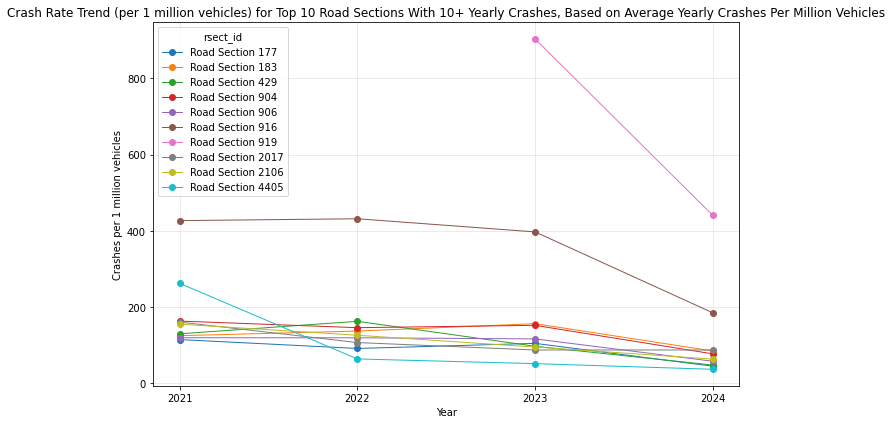

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
pdf2 = spark.sql("""
SELECT rsect_id, year, crashes_per_million
FROM crash_rate_view
WHERE avg_crashes >= 10
LIMIT 38
""").toPandas()

plt.figure(figsize=(9,6))
for rid, grp in pdf2.groupby('rsect_id'):
    plt.plot(grp['year'], grp['crashes_per_million'], marker='o', label=f"Road Section {rid}", linewidth=1)

plt.title("Crash Rate Trend (per 1 million vehicles) for Top 10 Road Sections With 10+ Yearly Crashes, Based on Average Yearly Crashes Per Million Vehicles")
plt.xlabel("Year")
plt.ylabel("Crashes per 1 million vehicles")
plt.xticks([2021, 2022, 2023, 2024])
plt.legend(title="rsect_id")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

>**Hourly Crash Rate (Crashes per Million Vehicles) by Year.**

In [102]:
spark.sql("""
CREATE OR REPLACE TEMP VIEW hourly_crash_rate_view AS
WITH vehicles AS (
  SELECT rsect_id,
         year,
         hours AS hour,
         (mon + tue + wed + thu + fri + sat + sun)/7.0 AS avg_hourly_vehicles
  FROM traffic
  WHERE rsect_id IS NOT NULL
),
crashes AS (
  SELECT rsect_id,
         crash_year AS year,
         crash_hour AS hour,
         COUNT(*) AS crash_count
  FROM crash
  WHERE rsect_id IS NOT NULL AND crash_hour IS NOT NULL
  GROUP BY rsect_id, crash_year, crash_hour
)
SELECT v.year,
       v.hour,
       SUM(c.crash_count) AS crashes,
       SUM(v.avg_hourly_vehicles) AS average_vehicles,
       (SUM(c.crash_count) / NULLIF(SUM(v.avg_hourly_vehicles),0)) * 1e6 AS crashes_per_million
FROM vehicles v
LEFT JOIN crashes c
  ON v.rsect_id = c.rsect_id AND v.year = c.year AND v.hour = c.hour
GROUP BY v.year, v.hour
ORDER BY v.year DESC, crashes_per_million DESC;""")
spark.sql("SELECT * FROM hourly_crash_rate_view LIMIT 24").show()

+----+----+-------+----------------+-------------------+
|year|hour|crashes|average_vehicles|crashes_per_million|
+----+----+-------+----------------+-------------------+
|2024|   3|    367|    24688.999993|       14864.919604|
|2024|   2|    377|    25940.571427|       14533.218787|
|2024|   1|    381|    37588.714257| 10136.021078000002|
|2024|   5|    896|    92590.571421|        9677.011236|
|2024|   4|    305|    34818.285701|        8759.764987|
|2024|  23|    631|   107101.714286|        5891.595706|
|2024|   6|   1302|   254902.857125|  5107.828192999999|
|2024|  22|    798|   166108.571420|        4804.086828|
|2024|   7|   1827|   425310.857153|        4295.681545|
|2024|   8|   2398|   596297.428582| 4021.4830470000006|
|2024|  21|    875|   218523.857131|        4004.139463|
|2024|  20|   1071|   281494.857148|        3804.687627|
|2024|  15|   2776|   731304.142858|        3795.958258|
|2024|  14|   2459|   671653.571423|        3661.113563|
|2024|  16|   2805|   767726.42

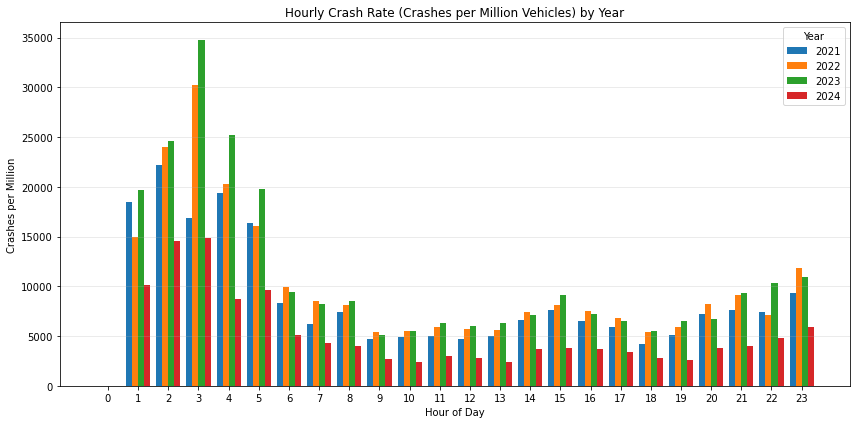

In [141]:
pdf = spark.sql("""
  SELECT year, hour, crashes_per_million
  FROM hourly_crash_rate_view
""").toPandas()

# Ensure proper types and full 0–23 hour coverage
pdf["hour"] = pdf["hour"].astype(int)
pivot = (pdf
         .pivot_table(index="hour", columns="year", values="crashes_per_million", aggfunc="mean")
         .reindex(range(24)))  # make sure hours 0..23 exist
pivot = pivot.fillna(0)

# 2) Set up grouped bars: one group per hour, bars within group = years
hours = np.arange(24)
years = sorted(pivot.columns)  # choose your order; e.g., sorted ascending
n_years = len(years)
bar_width = 0.8 / max(n_years, 1)  # total group width ~0.8

fig, ax = plt.subplots(figsize=(12, 6))

for i, yr in enumerate(years):
    # Offset each year's bar within the hour group
    ax.bar(hours + i*bar_width - 0.4 + bar_width/2,
           pivot[yr].values,
           width=bar_width,
           label=str(yr))

# 3) Cosmetics
ax.set_title("Hourly Crash Rate (Crashes per Million Vehicles) by Year")
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Crashes per Million")
ax.set_xticks(hours)
ax.set_xticklabels([str(h) for h in hours])
ax.grid(True, axis='y', alpha=0.3)
ax.legend(title="Year")  # wrap legend if many years
plt.tight_layout()
plt.show()

>**Severe Crash Rate vs Heavy Vehicle Share.**

In [128]:
spark.sql("""
CREATE OR REPLACE TEMP VIEW heavy_vehicle_crash_severity AS
WITH crash_census AS (
  SELECT
    c.rsect_id,
    c.traffic_year AS year,
    c.pc_class_0b   AS hv_share_pc,
    COUNT_IF(cr.crash_severity IN ('Fatal','Hospitalisation')) AS severe_crashes,
    COUNT(*) AS all_crashes
  FROM crash cr
  JOIN census c
    ON cr.rsect_id = c.rsect_id
   AND cr.crash_year = c.traffic_year
  WHERE cr.rsect_id IS NOT NULL
    AND c.pc_class_0b IS NOT NULL
  GROUP BY c.rsect_id, c.traffic_year, c.pc_class_0b
  HAVING COUNT(*) >= 5
),
hv_share_percentile AS (
  SELECT
    *,
    NTILE(10) OVER (ORDER BY hv_share_pc) AS band
  FROM crash_census
)
SELECT
  FORMAT_STRING('%s–%s%%', (band-1)*10, band*10) AS hv_percentile_band,
  SUM(severe_crashes) AS severe_crashes,
  SUM(all_crashes)    AS total_crashes,
  ROUND(SUM(severe_crashes) / SUM(all_crashes), 3) AS severe_rate
FROM hv_share_percentile
GROUP BY band
ORDER BY band;""")
spark.sql("SELECT * FROM heavy_vehicle_crash_severity LIMIT 24").show()

+------------------+--------------+-------------+-----------+
|hv_percentile_band|severe_crashes|total_crashes|severe_rate|
+------------------+--------------+-------------+-----------+
|             0–10%|         17903|        36451|      0.491|
|            10–20%|         21435|        44315|      0.484|
|            20–30%|         20579|        42384|      0.486|
|            30–40%|         21063|        45038|      0.468|
|            40–50%|         18895|        38183|      0.495|
|            50–60%|         14841|        29084|       0.51|
|            60–70%|         14825|        27755|      0.534|
|            70–80%|         12903|        23930|      0.539|
|            80–90%|         10682|        18665|      0.572|
|           90–100%|         14439|        27665|      0.522|
+------------------+--------------+-------------+-----------+



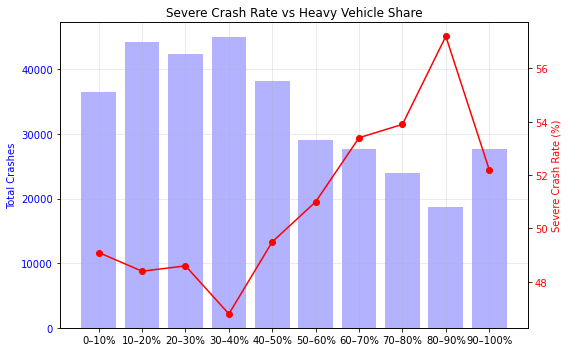

In [164]:
pdf = spark.sql("""
SELECT hv_percentile_band, severe_rate, total_crashes
FROM heavy_vehicle_crash_severity
""").toPandas()

fig, ax1 = plt.subplots(figsize=(8,5))



ax1.bar(pdf["hv_percentile_band"], pdf["total_crashes"], 
        alpha=0.3, color='blue', label='Total Crashes')
ax1.set_ylabel("Total Crashes", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, alpha=0.3, zorder=0)

ax2 = ax1.twinx()
ax2.plot(pdf["hv_percentile_band"], pdf["severe_rate"]*100, 
         marker='o', color='red', label='Severe Crash Rate (%)')
ax2.set_xlabel("Percentile Heavy Vehicle Share (%)")
ax2.set_ylabel("Severe Crash Rate (%)", color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title("Severe Crash Rate vs Heavy Vehicle Share")
plt.tight_layout()
plt.show()

>**Crash risk vs speed limit.**

In [159]:
spark.sql("""
CREATE OR REPLACE TEMP VIEW speed_limit_effect AS
WITH speed AS (
  SELECT rsect_id,
         traffic_year AS year,
         MAX(speed_limit) AS speed_limit,
         AVG(aadt) AS aadt_avg
  FROM census
  WHERE speed_limit IS NOT NULL AND aadt IS NOT NULL
  GROUP BY rsect_id, traffic_year
),
crashes AS (
  SELECT rsect_id, crash_year AS year, COUNT(*) AS crashes,
      COUNT_IF(crash_severity IN ('Fatal','Hospitalisation')) AS severe_crashes
  FROM crash
  WHERE rsect_id IS NOT NULL
  GROUP BY rsect_id, crash_year
)
SELECT s.speed_limit,
       SUM(c.crashes) AS crashes,
       (SUM(c.crashes) / SUM(s.aadt_avg * 365.0)) * 1e6 AS crashes_per_million,
       (SUM(c.severe_crashes) / SUM(c.crashes)) AS severe_rate
FROM speed s
JOIN crashes c ON s.rsect_id=c.rsect_id AND s.year=c.year
  WHERE s.aadt_avg > 0
GROUP BY s.speed_limit
ORDER BY s.speed_limit DESC;""")
spark.sql("SELECT * FROM speed_limit_effect LIMIT 20").show()

+-----------+-------+-------------------+-------------------+
|speed_limit|crashes|crashes_per_million|        severe_rate|
+-----------+-------+-------------------+-------------------+
|        100|   9400| 13.033849986119872| 0.5730851063829787|
|         90|   3399| 21.254222573971322|0.44954398352456604|
|         80|  11855| 13.025258900931536| 0.4727119358920287|
|         70|   7441|  20.09489091810827| 0.4304528961161134|
|         60|   7743| 20.899279780388976| 0.4704894743639416|
+-----------+-------+-------------------+-------------------+



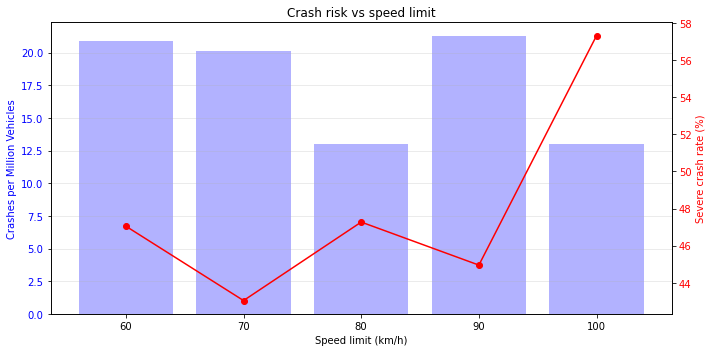

In [165]:
pdf = spark.sql("""
SELECT speed_limit, crashes, crashes_per_million, severe_rate
FROM speed_limit_effect
""").toPandas().sort_values('speed_limit')

fig, ax1 = plt.subplots(figsize=(10,5))

# Bars behind
ax1.bar(pdf['speed_limit'].astype(str), pdf['crashes_per_million'],
        alpha=0.3, color='blue', label='Crashes per Million Vehicles')
ax1.set_ylabel('Crashes per Million Vehicles', color='blue')
ax1.set_xlabel('Speed limit (km/h)')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, axis='y', alpha=0.3)

# Line in front
ax2 = ax1.twinx()
ax2.plot(pdf['speed_limit'].astype(str), pdf['severe_rate']*100, 
         marker='o', color='red', label='Severe rate (%)')
ax2.set_ylabel('Severe crash rate (%)', color='red' )
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Crash risk vs speed limit')
plt.tight_layout()
plt.show()